<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session7/blob/main/QnA_dataset_seq2seq_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Neural Machine Translation with Q/A Dataset**
Here we will be building a sequence to sequence deep learning model using PyTorch and TorchText for prediction of answers for given questions.Sequence to Sequence (seq2seq) model here uses an encoder-decoder architecture. Encoder neural network encodes the input sequence(question) into a single vector, also called as a Context Vector,which is an abstract representation of the input sequence.This vector is then passed into the decoder neural network, which is used to output the corresponding output sequence (answer), one word at a time

## Preparing Data
Import all the required modules and  set the random seeds for deterministic results.

In [ ]:
#importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim


from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time
import torch, torchtext
from torchtext import legacy
from torchtext.legacy import data
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
#setting  seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Mount drive to access dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/TSAI_data/QA_pairs/'

###Dataset 

We use Question/Answer dataset generated by students 
who took undergraduate natural language processing courses taught by Noah Smith 
at Carnegie Mellon and Rebecca Hwa at the University of Pittsburgh during 
Spring 2008, Spring 2009, and Spring 2010.

There are three files, one for each year of students: S08, S09, and S10.

Each file contains the questions and answers. The first line of the file contains 
column names for the tab-separated data fields in the file.
Let's merge all three files and create our final dataset

In [ ]:
file_1=pd.read_csv(path+"question_answer_pairs_s08.txt",sep='\t',encoding='ISO-8859-1')
file_2=pd.read_csv(path+"question_answer_pairs_s09.txt",sep='\t',encoding='ISO-8859-1')
file_3=pd.read_csv(path+"question_answer_pairs_s10.txt",sep='\t',encoding='ISO-8859-1')
files=[file_1,file_2,file_3]
df=pd.concat(files,axis=0)
df.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Let's view length of final dataset

In [ ]:
print(f'Length of dataset \n{len(df)}')

Length of dataset 
3998


Next we will do some preprocessing , will remove all unwanted columns for training and check if any nan rows are there

In [ ]:

df=df.iloc[:,1:3]
df=df.dropna().reset_index(drop=True)
df

,Question,Answer
0,Was Abraham Lincoln the sixteenth President of...,yes
1,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Did Lincoln sign the National Banking Act of 1...,yes
3,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Did his mother die of pneumonia?,no
...,...,...
3417,What areas do the Grevy's Zebras inhabit?,semi-arid grasslands of Ethiopia and northern ...
3418,Which species of zebra is known as the common ...,"Plains Zebra (Equus quagga, formerly Equus bur..."
3419,Which species of zebra is known as the common ...,Plains Zebra
3420,At what age can a zebra breed?,five or six


Let's split dataset into train and test for modeling

In [ ]:

(df_train, df_test) = train_test_split(df, test_size=0.3, random_state=random.seed(SEED))

assert len(df_train) + len(df_test) == len(df)
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [ ]:
len(df_train),len(df_test)

(2395, 1027)

In [ ]:
%%bash

python -m spacy download en --quiet
# python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Load spacy model for tokenizing

In [ ]:
# spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

We create the tokenizers.

In [ ]:
# def tokenize_an(text):
#     """
#     Tokenizes text from a string into a list of strings (tokens) and reverses it
#     """
#     return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_qn(text):
    """
    Tokenizes text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
### Sample Run ###

sample_text = "I love machine learning"
print(tokenize_qn(sample_text))


['I', 'love', 'machine', 'learning']


Here our source (SRC - Input) is `Question` and target (TRG - Output) is `Answer`. We also add 2 extra tokens "start of sequence"`<sos>` and "end of sequence"`<eos>` for effective model training.

In [ ]:
SRC = Field(tokenize = tokenize_qn, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_qn, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


Define fields to decide how we process data

In [ ]:
fields=[('Question',SRC),('Answer',TRG)]

In [ ]:
df_train

,Question,Answer
0,Does a violin have four strings?,Yes
1,Is Uruguay located in the northwesten part of ...,no
2,Did Charles-Augustin de Coulomb come from a po...,"No, his mother came from a wealthy family in t..."
3,What are Carleton University's athletic teams ...,Carleton Ravens
4,Why do kangaroos have a wide bite?,Because of grazing
...,...,...
2390,Why does the cornet have a slightly mellower t...,The cornet and flugelhorn have conical bores
2391,Does the Portuguese language have its roots in...,"Yes, Portuguese is derived from Latin."
2392,What are turtle eggs covered in when they incu...,mud or sand
2393,In what ways was Adams opposed by Anderw Hamil...,Hamilton wanted to control the army differentl...


In [ ]:
example_train=[data.Example.fromlist([df_train.Question[i],df_train.Answer[i]],fields) for i in range (df_train.shape[0])]
example_test=[data.Example.fromlist([df_test.Question[i],df_test.Answer[i]],fields) for i in range (df_test.shape[0])]

Now we create train and test dataset from list of rows 

In [ ]:
train_data = torchtext.legacy.data.Dataset(example_train, fields)
test_data= torchtext.legacy.data.Dataset(example_test,fields)

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 2395
Number of testing examples: 1027



Let's look at one of the examples in the training set

In [ ]:
print(vars(train_data.examples[0]))

{'Question': ['does', 'a', 'violin', 'have', 'four', 'strings', '?'], 'Answer': ['yes']}


Build vocabulary

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 2011
Unique tokens in target (en) vocabulary: 1271


Define device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create iterators

In [ ]:
BATCH_SIZE=32
train_iterator, test_iterator = BucketIterator.splits(
    (train_data,  test_data), 
    batch_size = BATCH_SIZE,sort_within_batch = True,
    sort_key = lambda x: len(x.Question),
    device = device)

### Build Model

 #### Encoder Model 

First, the encoder, a 2 layer `LSTM`.

For a multi-layer LSTM, the input sentence, $X$, after being embedded goes into the first (bottom) layer of the LSTM.Along with input sequence , LSTM take in hidden state and cell state from previous time step and return new hidden state and cell state at each time step.Initial hidden state and cell state will be initialized to tensor of all zeros.Only hidden state from the first layer is passed as input to the second layer, and not the cell state.We will also output a context vector per layer, $z^l$.Our context vector will be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Thus, representing each layer with a superscript, the hidden states in each layer are given by:

$$\begin{align*}
(h_t^1, c_t^1) = \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) = \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$
We create this in code by making an `Encoder` module, which inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. The encoder takes the following arguments:

*  `input_dim` is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.

*  `emb_dim` is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
*   `hid_dim` is the dimensionality of the hidden and cell states.
*   `n_layers` is the number of layers in the LSTM.
* `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting.


In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the embedding layer, and then dropout is applied. These embeddings are then passed into the LSTM. As we pass a whole sequence to the LSTM, it will automatically do the recurrent calculation of the hidden states over the whole sequence.We do not pass an initial hidden or cell state to the LSTM. This is because, if no hidden/cell state is passed to the LSTM, it will automatically create an initial hidden/cell state as a tensor of all zeros.

The `LSTM` returns: `outputs` (the top-layer hidden state for each time-step), hidden (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns hidden and cell.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        

        self.hid_dim = hid_dim
        
        # Number of layers in the lstm
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)

        

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        # Regularization parameter
        self.dropout = nn.Dropout(dropout)
  
    def forward(self, src):
        # print(f'En-shape of src{src.shape}')#[8, 32]
 
        embedded = self.dropout(self.embedding(src))
        # print(f'En-shape of embedded{embedded.shape}')#[8, 32, 256]

        outputs, (hidden, cell) = self.rnn(embedded)
        # print(f'En-shape of outputs{outputs.shape}')#[8, 32, 512]
        # print(f'En-shape of hidden{hidden.shape}')#[2, 32, 512]

        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

#### Decoder Model 

Next, we'll build our `decoder`, which will also be a 2-layer `LSTM`.

The Decoder class does a single step of decoding, i.e. it ouputs single token per time-step. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feeds it through the `LSTM` with the current embedded token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$
Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$.

$$\hat{y}_{t+1} = f(s_t^L)$$
The arguments and initialization are similar to the Encoder class, except we now have an output_dim which is the size of the vocabulary for the output/target. There is also the addition of the Linear layer, used to make the predictions from the top layer hidden state.

Within the forward method, we accept a batch of input tokens, previous hidden states and previous cell states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We unsqueeze the input tokens to add a sentence length dimension of 1. Then, similar to the encoder, we pass through an embedding layer and apply dropout. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. This produces an output (hidden state from the top layer of the RNN), a new hidden state (one for each layer, stacked on top of each other) and a new cell state (also one per layer, stacked on top of each other). We then pass the output (after getting rid of the sentence length dimension) through the linear layer to receive our prediction. We then return the prediction, the new hidden state and the new cell state.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        

        self.output_dim = output_dim

        self.hid_dim = hid_dim
        
        # Number of layers in the lstm
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        # Regularization parameter
        self.dropout = nn.Dropout(dropout)
    
    # Shape of input [batch_size]  
    def forward(self, input, hidden, cell):
        # print(f'De-shape of input{input.shape}')#[32]

        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        # print(f'De-shape of input{input.shape}')#[1, 32]
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        # print(f'De-shape of embedded{embedded.shape}') #[1,32,256]   
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # print(f'De-shape of output{output.shape}')#[1,32,512]
        # print(f'De-shape of hidden{hidden.shape}')#[2,32,512]
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
  
        prediction = self.fc_out(output.squeeze(0))# [32, 1271]
        # print(f'De-shape of prediction{prediction.shape}')
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

#### Seq2Seq (Encoder + Decoder) 

For the final part of the implemenetation, we'll implement the `seq2seq` model. This will handle:





*   receiving the input/source sentence
*   using the encoder to produce the context vectors
*   using the decoder to produce the predicted output/target sentence



The `Seq2Seq` model takes in an Encoder, Decoder, and a device (used to place tensors on the GPU, if it exists).



Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, 
$\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability 1 - `teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.

The first thing we do in the forward method is to create an outputs tensor that will store all of our predictions, $\hat{Y}$.


We then feed the input/source sentence, src, into the encoder and receive out final hidden and cell states.


The first input to the decoder is the start of sequence (`<sos>`) token. As our trg tensor already has the `<sos>` token appended we get our $y_1$ by slicing into it. We know how long our target sentences should be (max_len), so we loop that many times. The last token input into the decoder is the one before the <eos> token - the

During each iteration of the loop, we:

pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
place our prediction, $\hat{y}_{t+1}$/output in our tensor of predictions, $\hat{Y}$/outputs
decide if we are going to "teacher force" or not
if we do, the next input is the ground-truth next token in the sequence, $y_{t+1}$/trg[t]
if we don't, the next input is the predicted next token in the sequence, $\hat{y}_{t+1}$/top1, which we get by doing an argmax over the output tensor
Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/outputs

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## **Training Model**

We define the encoder, decoder and then our Seq2Seq model, which we place on the device.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)


Next step is initializing the weights of our model.We initialize all weights from a uniform distribution between -0.08 and +0.08. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform`.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2011, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1271, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=1271, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


We also define a function that will calculate the number of trainable parameters in the model.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,848,631 trainable parameters



We define our optimizer, which we use to update our parameters in the training loop. Here, we'll use Adam.

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=1e-4)

Next, we define our loss function as CrossEntropyLoss function. Our loss function calculates the average loss per token, however by passing the index of the <pad> token as the ignore_index argument we ignore the loss whenever the target token is a padding token.

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


Next, we'll define our training loop.

First, we'll set the model into "training mode" with model and then iterate through our data iterator.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        Question = batch.Question
        Answer = batch.Answer
        
        optimizer.zero_grad()
        
        output = model(Question, Answer)
        
        #Answer = [Answer len, batch size]
        #output = [Answer len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        Answer = Answer[1:].view(-1)
        
        #Answer = [(Answer len - 1) * batch size]
        #output = [(Answer len - 1) * batch size, output dim]
        
        loss = criterion(output, Answer)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll define our evaluation loop.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            Question = batch.Question
            Answer = batch.Answer

            output = model(Question, Answer, 0) #turn off teacher forcing

            #Answer = [Answer len, batch size]
            #output = [Answer len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            Answer = Answer[1:].view(-1)

            #Answer = [(Answer len - 1) * batch size]
            #output = [(Answer len - 1) * batch size, output dim]

            loss = criterion(output, Answer)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model . Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss.

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [ ]:
N_EPOCHS = 30
CLIP = 1
train_los=[]
test_los=[]
best_test_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    train_los.append(train_loss)
    test_loss = evaluate(model, test_iterator, criterion)
    test_los.append(test_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

Epoch: 01 | Time: 0m 3s
	Train Loss: 5.568 | Train PPL: 261.915
	 Test. Loss: 3.699 |  Test. PPL:  40.390
Epoch: 02 | Time: 0m 3s
	Train Loss: 4.425 | Train PPL:  83.518
	 Test. Loss: 3.640 |  Test. PPL:  38.108
Epoch: 03 | Time: 0m 3s
	Train Loss: 4.353 | Train PPL:  77.724
	 Test. Loss: 3.637 |  Test. PPL:  37.984
Epoch: 04 | Time: 0m 3s
	Train Loss: 4.336 | Train PPL:  76.403
	 Test. Loss: 3.602 |  Test. PPL:  36.662
Epoch: 05 | Time: 0m 3s
	Train Loss: 4.304 | Train PPL:  73.994
	 Test. Loss: 3.601 |  Test. PPL:  36.620
Epoch: 06 | Time: 0m 3s
	Train Loss: 4.282 | Train PPL:  72.415
	 Test. Loss: 3.571 |  Test. PPL:  35.564
Epoch: 07 | Time: 0m 3s
	Train Loss: 4.213 | Train PPL:  67.542
	 Test. Loss: 3.522 |  Test. PPL:  33.864
Epoch: 08 | Time: 0m 3s
	Train Loss: 4.151 | Train PPL:  63.503
	 Test. Loss: 3.429 |  Test. PPL:  30.859
Epoch: 09 | Time: 0m 3s
	Train Loss: 4.104 | Train PPL:  60.577
	 Test. Loss: 3.446 |  Test. PPL:  31.389
Epoch: 10 | Time: 0m 3s
	Train Loss: 4.079 | T

Let's view train and test loss of our model

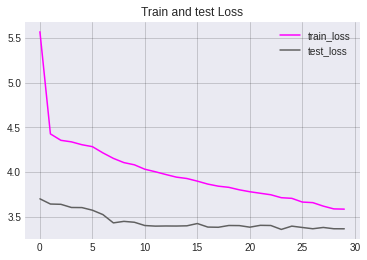

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_los, color = 'magenta')
plt.plot(test_los, color = '#606060')
plt.title('Train and test Loss')
plt.legend(['train_loss', 'test_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

## **Inference**


Now, we'll grab some answers to questions from our dataset and see how well our model did.

In [ ]:
def predict_answer(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        #('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        hidden,cell = model.encoder(src_tensor)

        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            # output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [ ]:
example_idx = 20

src = vars(train_data.examples[example_idx])['Question']
trg = vars(train_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['appreciated', 'during', 'his', 'lifetime', ',', 'did', 'his', 'fame', 'grow', 'in', 'the', 'years', 'after', 'his', 'death', '?']
trg = ['yes']


In [ ]:
pred_answer= predict_answer(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_answer}')

predicted trg = ['yes', '<eos>']


Let's predict some answers from test set too

In [ ]:

example_idx = 6

src = vars(test_data.examples[example_idx])['Question']
trg = vars(test_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['was', 'faraday', 'a', 'devout', 'christian', '?']
trg = ['yes']


In [ ]:
pred_answer= predict_answer(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_answer}')

predicted trg = ['yes', '<eos>']


In [ ]:
example_idx = 30

src = vars(test_data.examples[example_idx])['Question']
trg = vars(test_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['do', 'lobsters', 'feel', 'pain', '?']
trg = ['yes', '.']


In [ ]:
pred_answer= predict_answer(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_answer}')

predicted trg = ['yes', '<eos>']


In [ ]:
example_idx = 16

src = vars(test_data.examples[example_idx])['Question']
trg = vars(test_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['are', 'turtles', 'being', 'examined', 'for', 'longevity', 'genes', '?']
trg = ['yes']


In [ ]:
pred_answer= predict_answer(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_answer}')

predicted trg = ['yes', '<eos>']


In [ ]:
example_idx = 102

src = vars(test_data.examples[example_idx])['Question']
trg = vars(test_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['what', 'is', 'the', 'primary', 'item', 'in', 'an', 'otter', "'s", 'diet', '?']
trg = ['fish', '.']


In [ ]:
pred_answer= predict_answer(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_answer}')

predicted trg = ['<unk>', '<eos>']


In [ ]:
example_idx = 300

src = vars(test_data.examples[example_idx])['Question']
trg = vars(test_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['was', 'roosevelt', "'s", 'family', 'rich', '?']
trg = ['yes']


In [ ]:
pred_answer= predict_answer(src, SRC, TRG, model, device)

print(f'predicted trg = {pred_answer}')

predicted trg = ['no', '<eos>']
